In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
from collections import Counter, defaultdict
import json
import itertools
import csv
import pandas as pd
import operator
import copy

import matplotlib.pyplot as plt
import plotly.offline as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import networkx as nx

from scipy.sparse import coo_matrix

from tools.FileAccess.AbstractReader import JsonReader
from tools.url_parse.common import getdomain

from tools.DbAccess.DbInterface import DbInterface

/home/ubuntu/predicube/core/tools/FileAccess/AbstractReader.py:189: DeprecationWarning:

Call to deprecated function downloadFile (use copy instead).



In [4]:
from tools.FileAccess.JsonQuery import compileJsonQuery

filter_description = {
      "operator": "and", 
      "operands": [ 
        {
          "field": "province",
          "opstr": "intersects",
          "value": [ 
            "BE.VAN",
            "BE.VOV",
            "BE.VBR",
            "BE.VLI",
            "BE.VWV"
          ]
        },
        {
          "operator": "and", 
          "operands": [
            {
              "field": "urls", 
              "transform": "len", 
              "value": 0, 
              "opstr": "gt"
            }, 
            {
              "field": "adid_pixelids.[type==pixelid].identifier", 
              "value": [
                382,
                383,
                361,
                362,
                376,
                377,
                380,
                381,
                379,
                378,
                384,
                385,
                364,
                363
              ], 
              "opstr": "intersects"
            }
          ]
        }
      ]
    }

target_filter = {
    "operator": "and",
    "operands": [
        {
          "field": "province",
          "opstr": "intersects",
          "value": [ 
            "BE.VAN",
            "BE.VOV",
            "BE.VBR",
            "BE.VLI",
            "BE.VWV"
          ]
        },  
        {
          "operator": "and", 
          "operands": [
            {
              "field": "urls", 
              "transform": "len", 
              "value": 0, 
              "opstr": "gt"
            }, 
            {
              "field": "adid_pixelids.segments.identifier", 
              "value": [
                  "predicube_186_target"
              ], 
              "opstr": "intersects"
            }
          ]
        }
    ]
}

reference_filter =   {
    "operator": "and",
    "operands": [
        {
          "field": "province",
          "opstr": "intersects",
          "value": [ 
            "BE.VAN",
            "BE.VOV",
            "BE.VBR",
            "BE.VLI",
            "BE.VWV"
          ]
        },  
        {
              "field": "urls", 
              "transform": "len", 
              "value": 0, 
              "opstr": "gt"
        }
    ]
}

json_filter = compileJsonQuery(filter_description)
reference_filter = compileJsonQuery(reference_filter)
target_filter = compileJsonQuery(target_filter)

In [5]:
from pyspark import StorageLevel
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("test").getOrCreate()

input_path = "/home/ubuntu/data/tmp/uantwerpen/pid2info/part-00000"

target_rdd = spark.sparkContext.textFile(input_path).map(json.loads).filter(target_filter).persist(StorageLevel.MEMORY_AND_DISK)
reference_rdd = spark.sparkContext.textFile(input_path).map(json.loads).filter(reference_filter).persist(StorageLevel.MEMORY_AND_DISK)
#rdd = spark.sparkContext.textFile(input_path).map(json.loads).persist(StorageLevel.MEMORY_AND_DISK)


In [6]:
def get_domain_pairs(js):
    domains = {getdomain(url_rec["identifier"], no_subdomain=False) for url_rec in js.get("urls",[])}
    for d1, d2 in itertools.permutations(domains,2):
        yield ((d1,d2),1)
        
def get_domains(js):
    for url_rec in js.get("urls",[]):
        yield (getdomain(url_rec["identifier"],no_subdomain=False), 1)

In [7]:
def vertices_and_edges(rdd):
    vertices = rdd.flatMap(get_domains).reduceByKey(lambda x, y: x+y).collectAsMap()
    nvisits = sum(vertices.values())
    vertices = {vertex: 100.0*weight/nvisits for vertex, weight in vertices.items()}

    edges =  rdd.flatMap(get_domain_pairs).reduceByKey(lambda x, y: x+y).collect()
    npairs = sum([w for _, w in edges])
    edges = dict([(edge, 100.0*weight/npairs)  for edge, weight in edges])
    
    return vertices, edges

target_vertices, target_edges = vertices_and_edges(target_rdd)
ref_vertices, ref_edges = vertices_and_edges(reference_rdd)

In [8]:
def graph_lift(target, reference):
    lifts = {}
    for k, w in dict(target).items():
        lifts[k] = {
            "Lift": w / reference[k],
            "TargetRatio": w,
            "ReferenceRatio": reference[k]
        }
    return lifts

def merge_target_and_reference_graph(target_vertices, target_edges, ref_vertices, ref_edges):
    vertices = graph_lift(target_vertices, ref_vertices)
    edges = graph_lift(target_edges, ref_edges)
    return vertices, edges
    
vertices, edges = merge_target_and_reference_graph(target_vertices, target_edges, ref_vertices, ref_edges)



In [9]:
vertex2index = dict()

vertex_fieldnames = ["Id","Label","Lift","TargetRatio","ReferenceRatio"]

with open("/home/ubuntu/data/tmp/uantwerpen/vertices.ua.csv", "w") as fout:
    writer = csv.DictWriter(fout, fieldnames=vertex_fieldnames, quotechar = '"')
    writer.writeheader()
    for i, (v, d) in enumerate(vertices.items()):
        d["Label"] = v
        d["Id"] = i
        writer.writerow(d)
        
        vertex2index[v] = i
 
edge_fieldnames = ["Source","Target","Weight","Type","Lift","TargetRatio","ReferenceRatio"]

with open("/home/ubuntu/data/tmp/uantwerpen/edges.ua.csv", "w") as fout:
    writer = csv.DictWriter(fout, fieldnames=edge_fieldnames, quotechar = '"')
    writer.writeheader()
    for (v1,v2), d in edges.items():
        d["Source"] = vertex2index[v1]
        d["Target"] = vertex2index[v2]
        d["Weight"] = d["Lift"]
        d["Type"] = "undirected"
        writer.writerow(d)

In [10]:


vertices={}
edges = {}
index2vertex = {}

records = pd.read_csv("/home/ubuntu/data/tmp/uantwerpen/vertices.ua.csv").to_dict(orient="records")
for js in records:
    vertices[js["Label"]] = js
    index2vertex[js["Id"]] = js["Label"]
        
records = pd.read_csv("/home/ubuntu/data/tmp/uantwerpen/edges.ua.csv").to_dict(orient="records")
for js in records:
    srcid = index2vertex[js["Source"]]
    dstid = index2vertex[js["Target"]]
    edges[(srcid,dstid)] = js


In [47]:
def remove_isolated_nodes(G):
    reduced_G = copy.deepcopy(G)
    for nodeid in G.nodes():
        if nx.is_isolate(G,nodeid):
            reduced_G.remove_node(nodeid)
    return reduced_G
        
def sorted_edge_centrality(G, weight="weight", reverse=False):
    edge_centrality = nx.edge_betweenness_centrality(G, k=len(G.nodes()), weight=weight, normalized=False)
    return sorted(edge_centrality.items(), key=lambda x: x[1], reverse=reverse)

def minimal_connected_tree(G, weight="weight"):
    reduced_G = copy.deepcopy(G)
    edge_centrality = nx.edge_betweenness_centrality(G, k=len(G.nodes()), weight=weight, normalized=False)
    for ((u,v), _) in sorted_edge_centrality(G, weight=weight):
        d = G.edges()[(u,v)]
        reduced_G.remove_edge(u,v)
        if not nx.is_connected(reduced_G):
            reduced_G.add_edge(u,v,**d)
    return reduced_G

def create_graph(vertices, edges, weight_field="TargetRatio"):
    G=nx.Graph()
    
    for vertexid, d in vertices.items():
        d["weight"] = d[weight_field]
        G.add_node(vertexid, **d)
    
    for (v1,v2), d in edges.items():
        d["weight"] = d[weight_field]
        G.add_edge(v1,v2, **d)
        
    return G
  
def set_node_sizes(G, data_field="weight"):
    node_sizes = [d[data_field] for _, d in G.nodes(data=True)]
    max_size = max(node_sizes)
    node_sizes = {nodeid: 2000*d[data_field]/max_size for nodeid, d in G.nodes(data=True)}
    nx.set_node_attributes(G, node_sizes, "node_size")
    #return [2000*node_size/max_size for node_size in node_sizes]

def set_edge_widths(G, data_field="weight"):
    edge_sizes = [d[data_field] for _, _, d in G.edges(data=True)]
    max_size = max(edge_sizes)
    edge_widths = {(u,v): 5*d[data_field]/max_size for u, v, d in G.edges(data=True)}
    nx.set_edge_attributes(G, edge_widths, "edge_width")
    #return [5*edge_size/max_size for edge_size in edge_sizes]  

def filter_edges(G, field="weight", fieldvalue=1, op=operator.gt):
    reduced_G = copy.deepcopy(G)
    for (u, v, d) in G.edges(data=True):
        if not op(d[field],fieldvalue):
            reduced_G.remove_edge(u,v)
    return reduced_G
  
def filter_nodes(G, field="weight", fieldvalue=1, op=operator.gt):
    reduced_G = copy.deepcopy(G)
    for nodeid, d in G.nodes(data=True):
        if not op(d[fieldvalue],fieldvalue):
            reduce_G.remove_node(nodeid)
    return reduced_G
    
def plot_graph(G, pos=None):
    #remove_isolated_nodes(G)
    #minimal_connected_tree(G)

    plt.figure(figsize=(30,15))    
    
    if pos==None:
        pos = nx.spring_layout(G,k=5/np.sqrt(len(vertices)), weight="weight", scale=30)  # positions for all nodes

    #nx.draw_networkx_nodes(G, pos, nodelist=nodes2display, node_size=100)
    #nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    node_sizes = [d["node_size"] for _, d in G.nodes(data=True)]
    edge_widths = [d["edge_width"] for _, _, d in G.edges(data=True)]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, width=edge_widths)

    nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

    plt.axis('off')
    plt.show()
    
    return pos

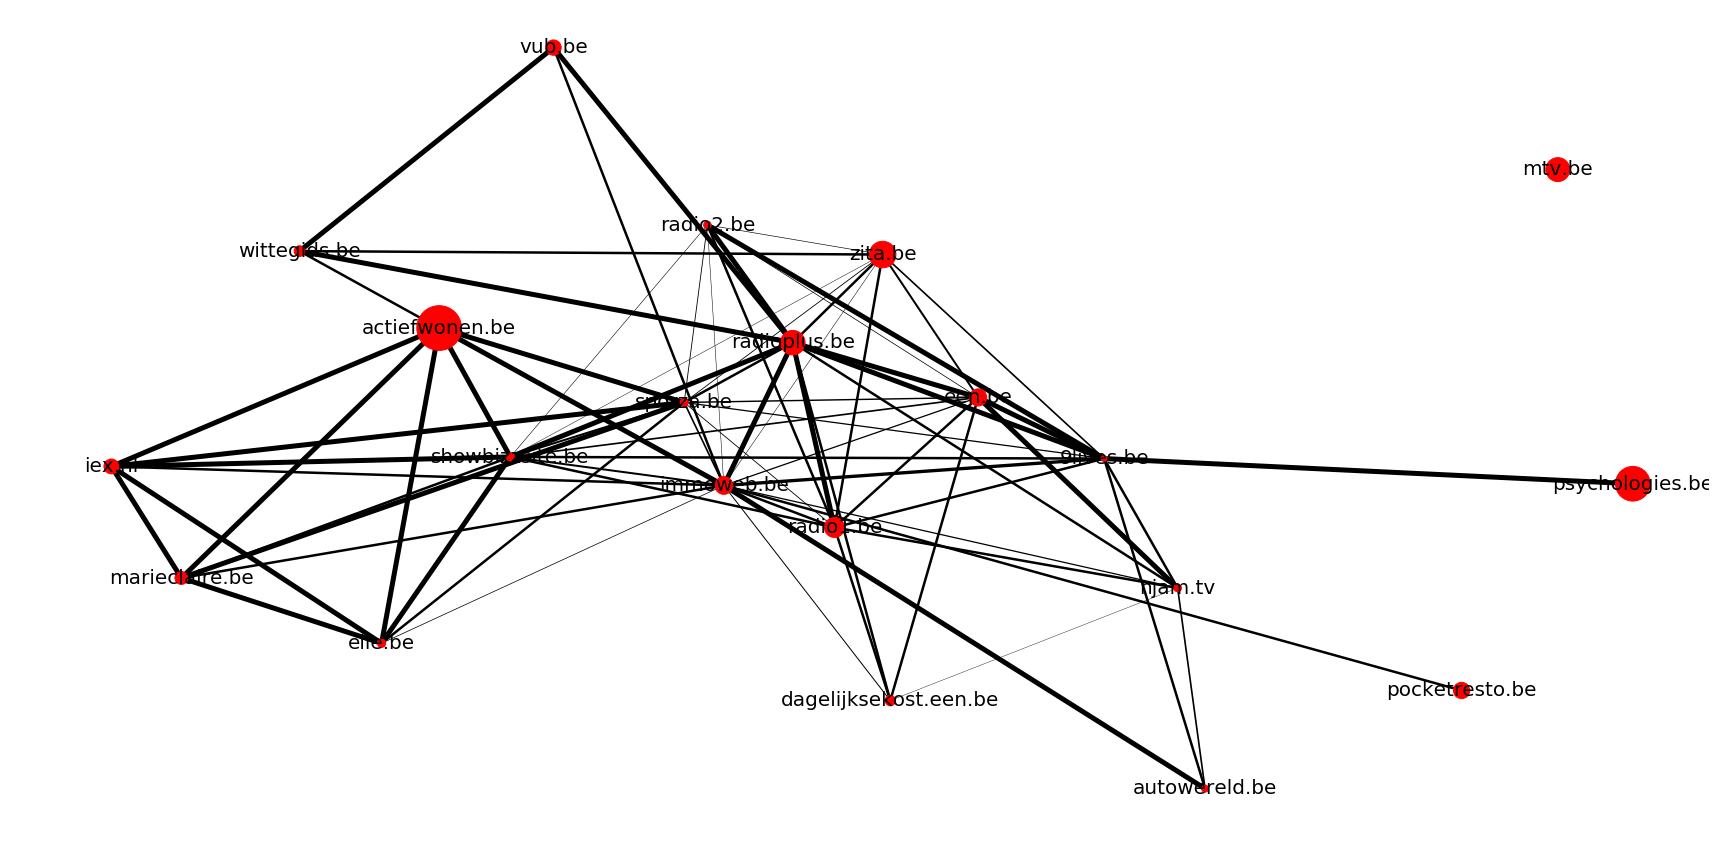

In [48]:
original_G = create_graph(vertices, edges)
set_node_sizes(original_G, data_field="Lift")
set_edge_widths(original_G, data_field="Lift")
#print original_G.edges(data=True)
original_pos = plot_graph(original_G)

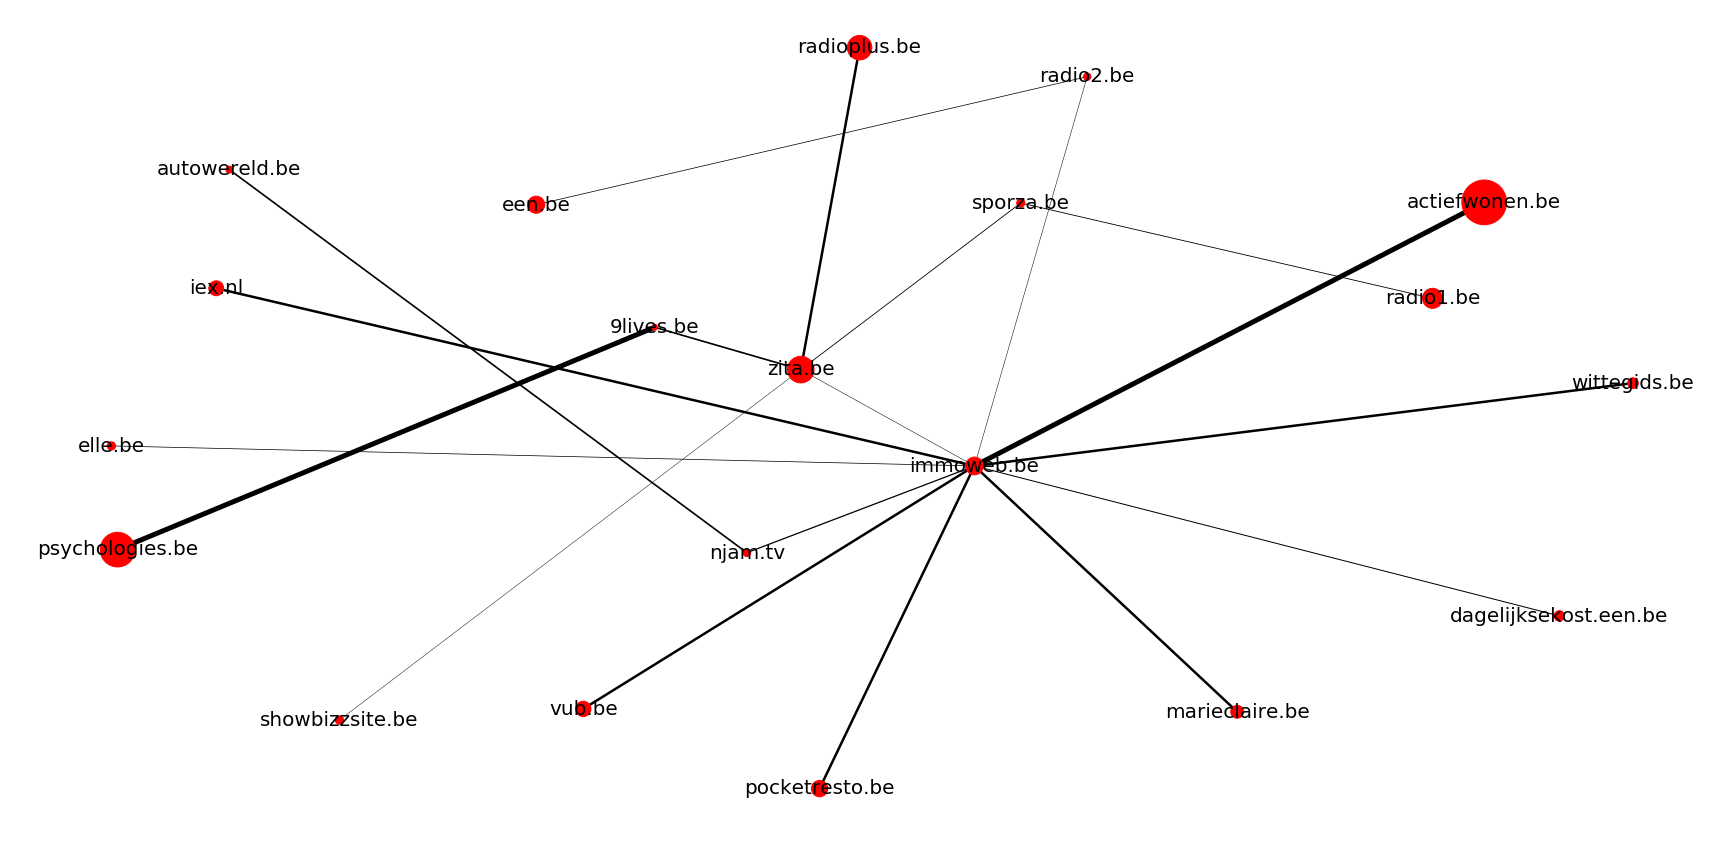

In [49]:
G2 = remove_isolated_nodes(original_G)
G2 = minimal_connected_tree(G2, weight="Lift")
set_node_sizes(G2, data_field="Lift")
set_edge_widths(G2, data_field="Lift")
#print original_G.edges(data=True)
pos2 = plot_graph(G2)

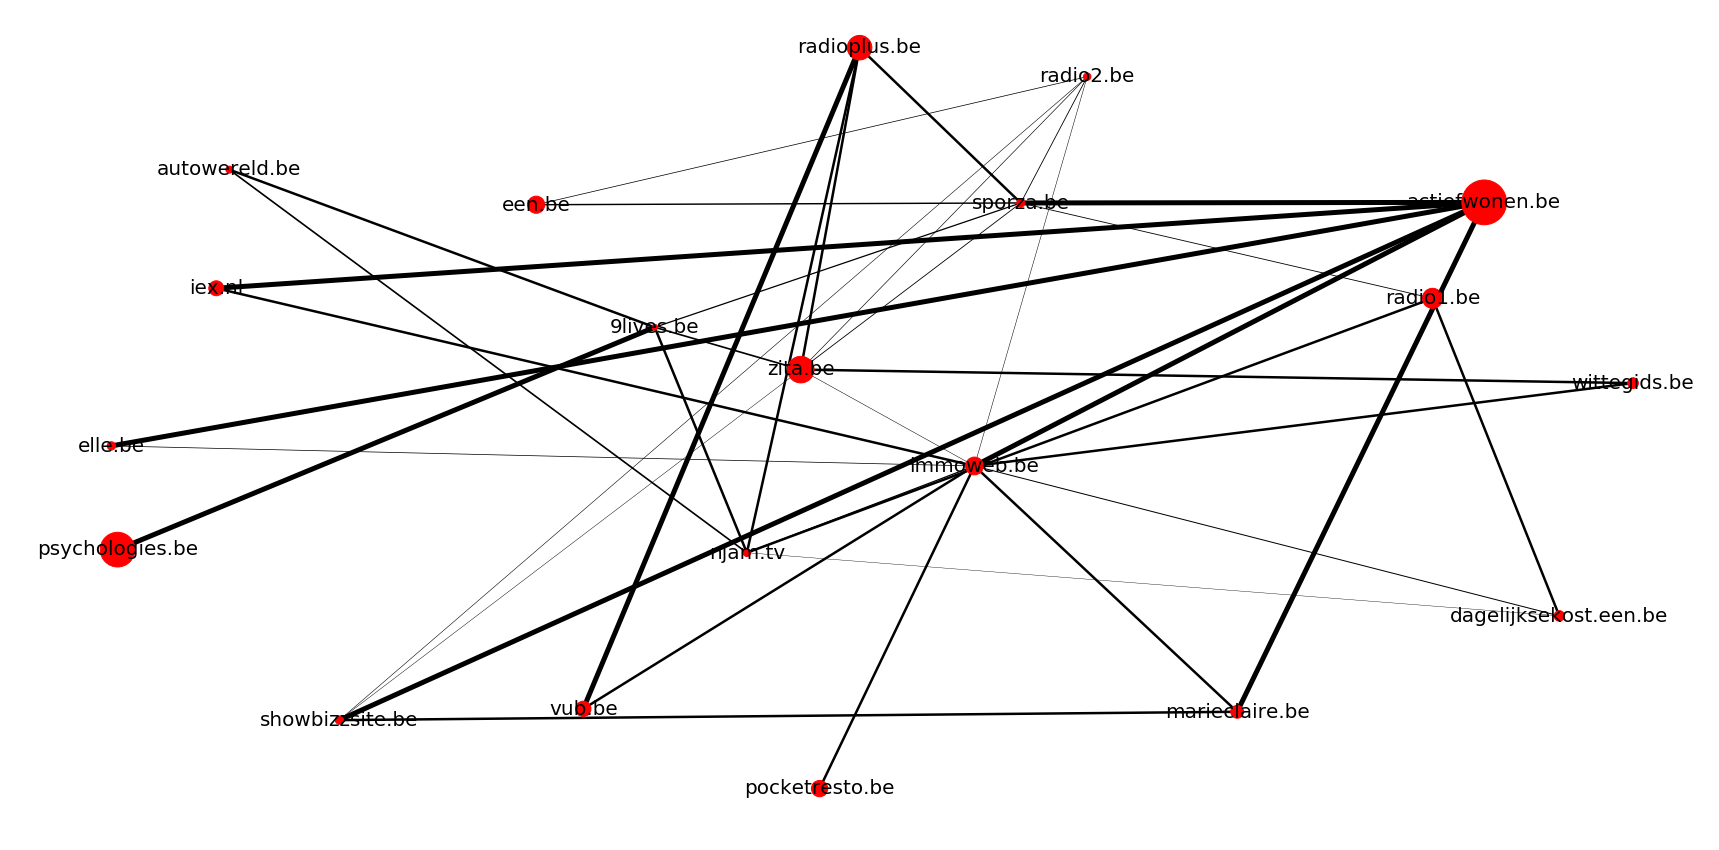

{'9lives.be': array([-6.19522835,  5.99250087]),
 'actiefwonen.be': array([24.49498759, 15.43941091]),
 'autowereld.be': array([-21.93364918,  17.914809  ]),
 'dagelijksekost.een.be': array([ 27.27231808, -15.83700988]),
 'een.be': array([-10.58147422,  15.26224559]),
 'elle.be': array([-26.29965168,  -2.98046861]),
 'iex.nl': array([-22.41898248,   8.94332019]),
 'immoweb.be': array([ 5.63417736, -4.49776303]),
 'marieclaire.be': array([ 15.35411275, -23.0896902 ]),
 'njam.tv': array([ -2.78595192, -11.05893121]),
 'pocketresto.be': array([ -0.09668544, -28.90062531]),
 'psychologies.be': array([-26.06937254, -10.82551701]),
 'radio1.be': array([22.58080585,  8.18229672]),
 'radio2.be': array([ 9.80522441, 24.94780173]),
 'radioplus.be': array([ 1.38459754, 27.14166263]),
 'showbizzsite.be': array([-17.86278317, -23.72039476]),
 'sporza.be': array([ 7.34810951, 15.39540513]),
 'vub.be': array([ -8.83906319, -22.86977159]),
 'wittegids.be': array([30.       ,  1.7703285]),
 'zita.be': 

In [52]:
def add_noncentral_edges(G, original_G, weight="weight", n=10):
    new_G = copy.deepcopy(G)
    counter = 0
    for ((u,v), _) in sorted_edge_centrality(original_G, weight=weight, reverse=True):
        if counter>=n:
            return new_G
        if (u,v) not in new_G.edges():
            new_G.add_edge(u,v, **original_G.edges()[(u,v)])
            counter += 1
    return new_G

G3 = add_noncentral_edges(G2, original_G, weight="Lift", n=20)
set_node_sizes(G3, data_field="Lift")
set_edge_widths(G3, data_field="Lift")
#print original_G.edges(data=True)
plot_graph(G3, pos2)
        

In [269]:
#ForceAtlas

def filter_edges(edges, min_weight = 1):
    for edge, weight in edges:
        if weight>=min_weight:
            yield (edge, weight)
            
def create_adjacency_matrix(edges):
    vertex_counter = itertools.count()
    vertex2index = defaultdict(lambda: vertex_counter.next())
    
    data = []
    rowindices = []
    colindices = []
    for (v1, v2), w in edges:
        data.append(w)
        rowindices.append(vertex2index[v1])
        colindices.append(vertex2index[v2])
        
    ndim = len(vertex2index)
    return coo_matrix((data,(rowindices,colindices)), shape=(ndim,ndim)), dict(vertex2index)

In [270]:
filtered_edges = [edge for edge in filter_edges(edges, 0.1)]

In [271]:
G, vertex2index = create_adjacency_matrix(filtered_edges)

In [272]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.10,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

vertex_positions = forceatlas2.forceatlas2 (G)

100%|██████████| 100/100 [00:00<00:00, 6167.19it/s]

('BarnesHut Approximation', ' took ', '0.00', ' seconds')
('Repulsion forces', ' took ', '0.00', ' seconds')
('Gravitational forces', ' took ', '0.00', ' seconds')
('Attraction forces', ' took ', '0.00', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '0.00', ' seconds')


In [278]:
def plot_graph(vertices, edges, vertex_positions, vertex2index):
    traces = []
    for (v1, v2), w in edges:
        x0, y0 = vertex_positions[vertex2index[v1]]
        x1, y1 = vertex_positions[vertex2index[v2]]
        traces.append(go.Scatter(
            x=[x0, x1], y=[y0, y1],
            line=dict(width=w, color='#888'),
            hoverinfo='none',
            mode='lines'
        ))
        
    node_x = []
    node_y = []
    node_names = []
    node_sizes = []
    for vertex, w in vertices.items():
        if vertex not in vertex2index:
            continue
        x, y = vertex_positions[vertex2index[vertex]]
        node_x.append(x)
        node_y.append(y)
        node_size = w
        node_names.append("{} ({:.2f}%)".format(vertex,node_size))
        node_sizes.append(node_size)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        marker=dict(
            size=node_sizes,
            sizemode='area',
            sizeref=2.*max(node_sizes)/(40.**2),
            sizemin=4
        ),
        text = node_names,
        textposition="bottom center",
        textfont=dict(
            family="sans serif",
            size=18,
            color="Green",
            
        ),
        hoverinfo='text')

    traces.append(node_trace)
    return traces

In [279]:
traces = plot_graph(vertices, filtered_edges, vertex_positions, vertex2index)

In [280]:
fig = go.Figure(data=traces,
             layout=go.Layout(
                title='Domains visited together',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                height=1500,
                width=2500,
                margin=go.layout.Margin(
                    l=200,
                    r=200,
                    b=200,
                    t=200,
                    pad=4
                ),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
py.iplot(fig, filename='lift-curves')

In [276]:
filtered_edges

[((u'www.magicmaman.com', u'www.rtbf.be'), 0.1214656859437209),
 ((u'www.een.be', u'www.immoweb.be'), 0.10122140495310075),
 ((u'www.rtbf.be', u'www.immoweb.be'), 0.7186719751670153),
 ((u'www.rtbf.be', u'www.lalibre.be'), 2.0547945205479454),
 ((u'rmcsport.bfmtv.com', u'www.lalibre.be'), 0.1889466225791214),
 ((u'www.immoweb.be', u'www.elle.be'), 0.18557257574735136),
 ((u'parismatch.be', u'www.rtbf.be'), 0.23618327822390175),
 ((u'www.logic-immo.be', u'www.dhnet.be'), 0.13833592010257104),
 ((u'www.immoweb.be', u'dagelijksekost.een.be'), 0.12483973277549093),
 ((u'www.lemonde.fr', u'www.lalibre.be'), 0.11471759228018084),
 ((u'forum.doctissimo.fr', u'www.lalibre.be'), 0.11134354544841082),
 ((u'www.lalibre.be', u'www.magicmaman.com'), 0.13158782643903097),
 ((u'www.pagesdor.be', u'www.immoweb.be'), 0.3407787300087725),
 ((u'www.lalibre.be', u'www.lemonde.fr'), 0.11471759228018084),
 ((u'www.dhnet.be', u'forum.doctissimo.fr'), 0.16870234158850125),
 ((u'www.dhnet.be', u'www.psychologi

In [277]:
vertex2index

{u'dagelijksekost.een.be': 10,
 u'forum.doctissimo.fr': 12,
 u'lessportsplus.dhnet.be': 21,
 u'njam.tv': 31,
 u'parismatch.be': 7,
 u'people.bfmtv.com': 32,
 u'radio2.be': 28,
 u'radioplus.be': 16,
 u'rmcsport.bfmtv.com': 5,
 u'sporza.be': 27,
 u'stubru.be': 17,
 u'www.01net.com': 18,
 u'www.9lives.be': 30,
 u'www.autogids.be': 33,
 u'www.bfmtv.com': 26,
 u'www.cosmopolitan.fr': 15,
 u'www.dhnet.be': 9,
 u'www.doctissimo.fr': 19,
 u'www.een.be': 2,
 u'www.elle.be': 6,
 u'www.elle.fr': 22,
 u'www.goudengids.be': 23,
 u'www.immoweb.be': 3,
 u'www.lalibre.be': 4,
 u'www.lemonde.fr': 11,
 u'www.logic-immo.be': 8,
 u'www.magicmaman.com': 0,
 u'www.marieclaire.fr': 29,
 u'www.moniteurautomobile.be': 20,
 u'www.pagesdor.be': 13,
 u'www.psychologies.com': 14,
 u'www.rtbf.be': 1,
 u'www.showbizzsite.be': 25,
 u'www.zita.be': 24}